In [33]:
import os, sys, time, glob, shutil

import nipype
import nipype.interfaces.io as nio           # Data i/o
import nipype.interfaces.spm as spm          # spm
import nipype.interfaces.fsl as fsl    # fsl
import nipype.interfaces.utility as util     # utility
import nipype.pipeline.engine as pe          # pypeline engine
import nipype.algorithms.rapidart as ra      # artifact detection
import nipype.algorithms.modelgen as model   # model specification
import nipype.interfaces.nipy.preprocess as preprocess

sys.path.append('/data/hangyee')
import nipype_init

nipype_init.init()

In [22]:
import glob

for f in glob.glob('../nifti/native/picture/*.nii.gz'):
    print f
    !{'gunzip '+f}
for f in glob.glob('../nifti/native/brand/*.nii.gz'):
    print f
    !{'gunzip '+f}    

../nifti/native/picture/S4_picture_native.nii.gz
../nifti/native/picture/S5_picture_native.nii.gz
../nifti/native/picture/S6_picture_native.nii.gz
../nifti/native/picture/S7_picture_native.nii.gz
../nifti/native/picture/S8_picture_native.nii.gz
../nifti/native/picture/S9_picture_native.nii.gz
../nifti/native/picture/S10_picture_native.nii.gz
../nifti/native/picture/S11_picture_native.nii.gz
../nifti/native/picture/S12_picture_native.nii.gz
../nifti/native/picture/S13_picture_native.nii.gz
../nifti/native/picture/S14_picture_native.nii.gz
../nifti/native/picture/S15_picture_native.nii.gz
../nifti/native/picture/S16_picture_native.nii.gz
../nifti/native/picture/S17_picture_native.nii.gz
../nifti/native/picture/S18_picture_native.nii.gz
../nifti/native/picture/S19_picture_native.nii.gz
../nifti/native/picture/S20_picture_native.nii.gz
../nifti/native/picture/S22_picture_native.nii.gz
../nifti/native/picture/S23_picture_native.nii.gz
../nifti/native/picture/S24_picture_native.nii.gz
../nif

In [55]:
def get_picture_category_info(subj,method):
    from nipype.interfaces.base import Bunch
    import scipy.io as spio 
    
    subjectinfo = []

    log_file = '../log/S'+str(subj)+'_picture.csv'
    nuisance_file = '../nuisance/'+method+'/S'+str(subj)+'_picture_nuisance.txt'
    brightness_file = '../nuisance/'+method+'/S'+str(subj)+'_picture_brightness.txt'
    contrast_file = '../nuisance/'+method+'/S'+str(subj)+'_picture_contrast.txt'

    with open(nuisance_file) as f:
        nuisance = f.readlines()
    reg1 = []
    reg2 = []
    for nuisance_line in nuisance:
        a = nuisance_line.split(' ')
        if len(a) == 2:
            reg1.append(float(a[0]))
            reg2.append(float(a[1]))
            
    with open(brightness_file) as f:
        brightness = f.readlines()
    brightness_reg = [float(b) for b in brightness]

    with open(contrast_file) as f:
        contrast = f.readlines()
    contrast_reg = [float(c) for c in contrast]

    log = np.recfromcsv(log_file,delimiter=',')
    
    #condition_names = np.hstack([np.unique(log.category),['brightness','contrast']])
    condition_names = np.unique(log.category)
    durations = [[] for i in range(len(condition_names))]
    onsets = [[] for i in range(len(condition_names))]
    
    for log_line in log:
        idx = np.ravel(np.where(condition_names == log_line.category))[0]
        onsets[idx].append(log_line.onset)
        durations[idx].append(float(7))
        
        #onsets[-2].append(log_line.onset)
        #onsets[-1].append(log_line.onset)
        
        #durations[-2].append(float(7))
        #durations[-1].append(float(7))
    
    #pmod = [None for i in range(len(condition_names))] + [Bunch(name=['brightness'], param=[log.brightness.tolist()],
    #                                 poly=[1]), Bunch(name=['contrast'], param=[log.contrast.tolist()],
    #                                 poly=[1])]
    
    subjectinfo.append(Bunch(conditions=['a' ,'b']condition_names.tolist(),
                                 onsets=[[1,3,4],[3,4,5]]onsets,
                                 durations=durations,
                                 #pmod=pmod,
                                 regressor_names=['R1','R2','R3','R4'],
                                 regressors=(list(reg1),list(reg2),brightness_reg,contrast_reg)))
        
    return subjectinfo

In [39]:
for subj in range(4,42):
    os.mkdir('../spm/normalized/brand/S'+str(subj))
    #os.mkdir('../spm/normalized/picture/S'+str(subj)+'/by_category')

In [116]:
import glob
TR = 2.3

for subj in range(4,42):
    method = 'normalized'

    log_file = '../log/S'+str(subj)+'_picture.csv'
    log = np.recfromcsv(log_file,delimiter=',')
    nvols = len(log)

    starttime = time.time()

    print "S%d"%subj,

    for f in glob.glob('../spm/normalized/picture/S'+str(subj)+'/by_category/*.*'):
        os.remove(f)

    print "Specify model",
    modelspec = model.SpecifySPMModel()

    modelspec.inputs.input_units='secs'
    modelspec.inputs.output_units='secs'
    modelspec.inputs.time_repetition=TR
    modelspec.inputs.high_pass_filter_cutoff=128
    modelspec.inputs.functional_runs = ['../nifti/'+method+'/picture/S'+str(subj)+'_picture_'+method+'.nii']
    modelspec.inputs.subject_info = get_picture_category_info(subj,method)

    out = modelspec.run()

    print "- Design",
    level1design = spm.Level1Design()
    level1design.inputs.timing_units = 'secs'
    level1design.inputs.interscan_interval = TR
    level1design.inputs.bases = {'hrf':{'derivs': [0,0]}}
    level1design.inputs.model_serial_correlations = 'AR(1)'
    level1design.inputs.session_info = out.outputs.session_info

    out = level1design.run()

    shutil.move(out.outputs.spm_mat_file,'../spm/normalized/picture/S'+str(subj)+'/by_category')

    print "- Estimate",
    level1estimate = spm.EstimateModel()
    level1estimate.inputs.estimation_method = {'Classical': 1}
    level1estimate.inputs.spm_mat_file = '../spm/normalized/picture/S'+str(subj)+'/by_category/SPM.mat'

    out = level1estimate.run()

    print "- Contrast",
    level1contrast = spm.EstimateContrast()
    level1contrast.inputs.spm_mat_file = out.outputs.spm_mat_file
    level1contrast.inputs.beta_images = out.outputs.beta_images
    level1contrast.inputs.residual_image = out.outputs.residual_image
    cont1 = ('family>party','T', ['family','party'],[1,-1])
    cont2 = ('family>sex','T', ['family','sex'],[1,-1])
    cont3 = ('family>work','T', ['family','work'],[1,-1])
    cont4 = ('party>sex','T', ['party','sex'],[1,-1])
    cont5 = ('party>work','T', ['party','work'],[1,-1])
    cont6 = ('sex>work','T', ['sex','work'],[1,-1])
    contrasts = [cont1,cont2,cont3,cont4,cont5,cont6]
    level1contrast.inputs.contrasts = contrasts

    out = level1contrast.run()

    print "- %f"%(time.time()-starttime)

S4 Specify model - Design - Estimate - Contrast - 131.905188
S5 Specify model - Design - Estimate - Contrast - 151.655966
S6 Specify model - Design - Estimate - Contrast - 133.336988
S7 Specify model - Design - Estimate - Contrast - 140.991142
S8 Specify model - Design - Estimate - Contrast - 133.625154
S9 Specify model - Design - Estimate - Contrast - 143.830131
S10 Specify model - Design - Estimate - Contrast - 133.765783
S11 Specify model - Design - Estimate - Contrast - 135.517913
S12 Specify model - Design - Estimate - Contrast - 136.292012
S13 Specify model - Design - Estimate - Contrast - 136.523748
S14 Specify model - Design - Estimate - Contrast - 137.989338
S15 Specify model - Design - Estimate - Contrast - 135.548830
S16 Specify model - Design - Estimate - Contrast - 140.941028
S17 Specify model - Design - Estimate - Contrast - 142.204413
S18 Specify model - Design - Estimate - Contrast - 164.612134
S19 Specify model - Design - Estimate - Contrast - 138.822848
S20 Specify mo

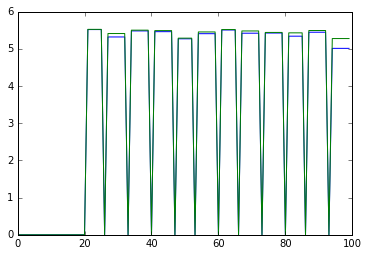

In [48]:
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt
import scipy.io as spio
subj = 4
a = spio.loadmat('../spm/normalized/brand/S4/T4O0/SPM.mat')
ff = open('../nuisance/S4_brand_brightness.txt').readlines()
b = [float(f) for f in ff]
ff = open('../nuisance/S4_brand_contrast.txt').readlines()
c = [float(f) for f in ff]

def zscore(x):
    return (x-np.mean(x))/np.std(x)

reg = a['SPM']['xX'][0][0]['X'][0][0]

#plt.plot(reg[0:100,0])
#plt.plot(reg[0:100,1])
#plt.plot(reg[0:100,2])
#plt.plot(reg[0:100,3])
#plt.plot(reg[0:100,-3]+4)
#plt.plot(reg[0:100,-2])
#plt.plot(zscore(reg[0:100,-3]))
#plt.plot(b[0:100])
#plt.plot(c[0:100])

#plt.show()

In [3]:
con_dir = ['family-party','family-sex','family-work','party-sex','party-work','sex-work']

for con in range(1,7):
    print con_dir[con-1],
    
    if os.path.exists('SPM.mat'):
        os.remove('SPM.mat')
    for f in glob.glob('../spm/normalized/picture/category/'+con_dir[con-1]+'/*.*'):
        os.remove(f)
    
    starttime = time.time()    
    
    onesamplettestdes = spm.OneSampleTTestDesign()
    onesamplettestdes.inputs.in_files = glob.glob('../spm/normalized/picture/S*/by_category/con_%04d.nii'%con)

    out = onesamplettestdes.run()

    shutil.move(out.outputs.spm_mat_file,'../spm/normalized/picture/category/'+con_dir[con-1])

    level2estimate = spm.EstimateModel()
    level2estimate.inputs.estimation_method = {'Classical': 1}
    level2estimate.inputs.spm_mat_file = '../spm/normalized/picture/category/'+con_dir[con-1]+'/SPM.mat'

    out = level2estimate.run()
    
    level2contrast = spm.EstimateContrast()
    level2contrast.inputs.spm_mat_file = out.outputs.spm_mat_file
    level2contrast.inputs.beta_images = out.outputs.beta_images
    level2contrast.inputs.residual_image = out.outputs.residual_image
    
    cont1 = ('pos','T', ['mean'],[1])
    cont2 = ('neg','T', ['mean'],[-1])
    level2contrast.inputs.contrasts = [cont1,cont2]
    level2contrast.inputs.group_contrast = True
    
    out = level2contrast.run()
    
    print "- %f"%(time.time()-starttime)

family-party - 50.592543
family-sex - 48.996974
family-work - 54.470796
party-sex - 55.915926
party-work - 65.047138
sex-work - 225.596510


In [150]:
con_dir = ['family-party','family-sex','family-work','party-sex','party-work','sex-work']

for con in range(1,7):
    print con_dir[con-1],

    thresh = spm.Threshold()
    thresh.inputs.spm_mat_file = '../spm/normalized/picture/category/'+con_dir[con-1]+'/SPM.mat'
    thresh.inputs.stat_image = '../spm/normalized/picture/category/'+con_dir[con-1]+'/spmT_0001.nii'
    thresh.inputs.contrast_index = 1
    thresh.inputs.extent_fdr_p_threshold = 0.05
    out = thresh.run()
    shutil.move(out.outputs.thresholded_map,'../spm/normalized/picture/category/'+con_dir[con-1])

    thresh.inputs.spm_mat_file = '../spm/normalized/picture/category/'+con_dir[con-1]+'/SPM.mat'
    thresh.inputs.stat_image = '../spm/normalized/picture/category/'+con_dir[con-1]+'/spmT_0002.nii'
    thresh.inputs.contrast_index = 1
    thresh.inputs.extent_fdr_p_threshold = 0.05
    out = thresh.run()
    shutil.move(out.outputs.thresholded_map,'../spm/normalized/picture/category/'+con_dir[con-1])

family-party family-sex family-work party-sex party-work sex-work


In [151]:
import mvpa2.suite as mvpa2
roi_files = glob.glob('../spm/normalized/picture/category/*/spmT*thr.nii')
ds = mvpa2.fmri_dataset(roi_files)

roi_mask = np.nansum(ds.samples,axis=0)
roi_mask_file = mvpa2.map2nifti(ds,data=roi_mask)
roi_mask_file.to_filename('../roi/normalized/common_mask/spm/picture2.nii')

In [152]:
np.sum(roi_mask > 0)

2893